In [66]:
import urllib
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

DATASET = "VDH-COVID-19-PublicUseDataset-Cases.csv"
COUNTIES = frozenset({"Alexandria", "Arlington","Fairfax"})

data = pd.read_csv(os.path.join("./data", DATASET))
data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,6/28/2020,51001,Accomack,Eastern Shore,1039,71,14
1,6/28/2020,51003,Albemarle,Thomas Jefferson,393,28,8
2,6/28/2020,51005,Alleghany,Alleghany,31,5,2
3,6/28/2020,51007,Amelia,Piedmont,42,11,1
4,6/28/2020,51009,Amherst,Central Virginia,35,3,0


In [67]:
total_cases = pd.DataFrame(
    data[data["Locality"].isin(COUNTIES)].groupby("Report Date")["Total Cases"].agg("sum")
)
total_cases.reset_index(inplace=True)
total_cases["Datetime"] = pd.to_datetime(total_cases["Report Date"])
total_cases.sort_values(by="Datetime", inplace=True)

total_cases["Daily"] = total_cases["Total Cases"].diff()
total_cases["7 day avg"] = total_cases["Daily"].rolling(7).mean()
change = total_cases["7 day avg"].pct_change().to_list()

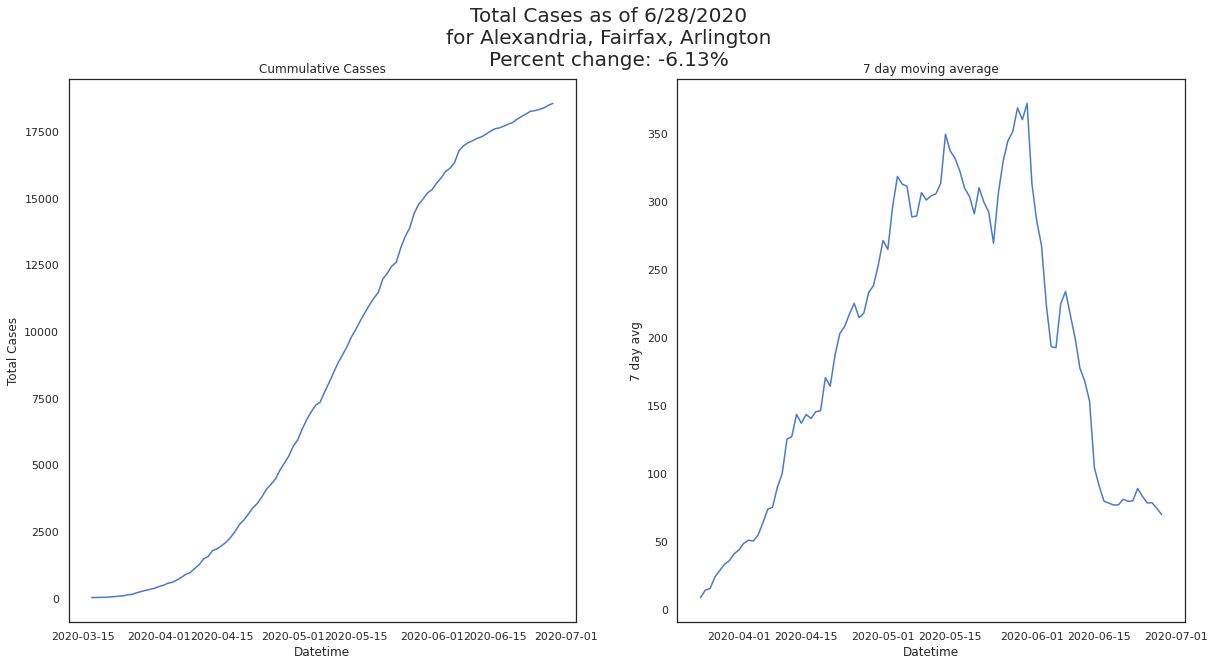

In [71]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 2, figsize=(20,10))

#sns.barplot(x=total_cases["Datetime"], y = total_cases["Daily"], )
left = sns.lineplot(x="Datetime", y="Total Cases", data=total_cases, ax=axes[0])
right = sns.lineplot(x="Datetime", y ="7 day avg", data=total_cases, ax=axes[1])

left.set_title("Cummulative Casses")
right.set_title("7 day moving average")
title = (f"Total Cases as of {total_cases.iloc[-1]['Report Date']}\n"
         f"for {', '.join([county for county in COUNTIES])}\n"
         f"Percent change: {change[-1]*100:.2f}%\n"
        )
a = f.suptitle(title, fontsize=20)
plt.show()